In [1]:
# sys, file and nav packages:
import os
import datetime as dt
import csv
import json

# math packages:
import pandas as pd
import numpy as np
import math

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# home brew utitilties
import utilities.utility_functions as ut
import utilities.abundance_classes as ac

# chart kwargs
title_k = {'loc':'left', 'pad':14, 'linespacing':1.5, 'fontsize':12}
title_k14 = {'loc':'left', 'pad':16, 'linespacing':1.5, 'fontsize':14}
xlab_k = {'labelpad':10, 'fontsize':12}
xlab_k14 = {'labelpad':14, 'fontsize':14}

# easy variables to the directory tree
survey_data, location_data, code_defs, stat_ent, geo_data, output = ut.make_local_paths()

In [2]:
# set some parameters:
start_date = '2020-04-01'
end_date ='2021-04-01'

today = dt.datetime.now().date().strftime("%Y-%m-%d")


# name the folder:
name_of_project = 'projectdescription'

# use this to store things:
project_directory = ut.make_project_folder(output, name_of_project)

# keep track of output
files_generated = []
figure_num = 0
data_num = 0

# kwargs for the abundance class
group_names_locations = {
    "waste water": "wastewater.json" ,
    "less than 5mm":"codeListMicros.json",
    "construction":"construction.json",
    "food":"foodstuff.json",
    "agg-con-trans":"cat.json",
    "agriculture":"ag.json",
    "tobacco":"tobac.json",
    "recreation":"recreation.json",    
    "packaging non food":"packaging.json",
    "personal items":"pi.json",    
}

frag_plas = {"fragmented plastics":["G79", "G78", "G75"]}

# convenience method to organize output
def add_output(**kwargs):
    files_generated.append({'tag':kwargs['tag'], 'number':kwargs['figure_num'], 'file':kwargs['file'],'type':kwargs['a_type']})
    if kwargs['a_type'] == 'data':
        kwargs['data'].to_csv(F"{kwargs['file']}.csv", index=False)
    else:
        plt.savefig(F"{kwargs['file']}.jpeg", dpi=300)
        

print(F"\nThis is the output directory for this notebook:\n\n   {project_directory}\n\nIt can be called by typing 'project_directory'\n")


This is the output directory for this notebook:

   output/projectdescription

It can be called by typing 'project_directory'



In [3]:
# non aggregated survey data
# Zero values are assigned for all codes not identified at a survey, for each survey
dfSurveys = pd.read_csv(F"{survey_data}/results_with_zeroes.csv")

# house keeping
dfSurveys = dfSurveys[(dfSurveys.date >= start_date)&(dfSurveys.date <= end_date)]
dfSurveys['date'] = pd.to_datetime(dfSurveys['date'], format="%Y-%m-%d")

# river bassin labels
river_bassins = ut.json_file_get(F"{location_data}/river_basins.json")

# beach data
dfBeaches = pd.read_csv(F"{location_data}/beaches_with_ranks.csv")
dfBeaches.set_index('slug', inplace=True)

# assign river bassin labels to locations:
for k,v in river_bassins.items():
    dfBeaches.loc[dfBeaches.water_name.isin(v), 'river_bassin'] = k

# code definitions
dfCodes = pd.read_csv(F"{code_defs}/mlw_codes.csv", index_col='code')

# dimensional data
dfDims = pd.read_csv(F"{survey_data}/dims_data.csv")
# the loc date key needs updating:
dfDims['loc_date'] = list(zip(dfDims.location, dfDims.date))

# project lakes and beaches:
project_lakes = ut.json_file_get(F"{location_data}/project_lakes.json")
project_beaches = ut.json_file_get(F"{location_data}/project_beaches.json")

In [4]:
# make a copy of the survey data and tag the records as either lake or river:
data = dfSurveys.copy()

# map lake or river from dfBeaches
lakes = dfBeaches[dfBeaches.water == 'l'].water_name.unique()
rivers = dfBeaches[dfBeaches.water == 'r'].water_name.unique()

# map values to new column t:
data['type'] = 't'
for a_place in data.water_name.unique():
    data.loc[data.water_name.isin(lakes), 'type'] = 'l'
    data.loc[data.water_name.isin(rivers), 'type'] = 'r'

# check if there any un categorized records:
if len(data[data['type']=='t']) > 0:
    print(F"\nThere are {len(data[data['type']=='t'])} records that were not classified as either lake or river:\n\n{data[data['type']=='t']}\n")
else:
    pass

## <span style="color:#008891">Description of survey results: temporal, geopgraphic and administrative scope</span>

In [5]:
# put the data into a class
a_class_kwargs = dict(
    code_group_data=group_names_locations,
    new_code_group=frag_plas,
    levels=['river_bassin', 'water_name', 'city'],
    river_bassins=river_bassins,
    exp_variables=['population','buildings', 'streets', 'intersects', 'pop_group_proj', 'pop_group_rip', 'streets_rank', 'buildings_rank'],
    code_group_loc=output,
)
a = ac.PreprocessData(data, dfBeaches,**a_class_kwargs)
# define the final data set here:
a_data = a.survey_data[a.survey_data.river_bassin != 'reuss'].copy()

# describe the data set:
num_obs = len(a_data)
num_samps = len(a_data.loc_date.unique())
num_obj = a_data.quantity.sum()
num_locs = len(a_data.location.unique())
num_rivs = a_data[a_data['type']=='r'].water_name.nunique()
num_lakes = a_data[a_data['type'] == 'l'].water_name.nunique()

# number of municipalities
a_map = dfBeaches['city']
munis = [a_map[x] for x in a_data.location.unique()]
munis = list(set(munis))
num_munis = len(munis)

# population
total_pop_d = dfBeaches.loc[a_data.location.unique()][['city', 'population']]
total_pop_c = total_pop_d.drop_duplicates('city')
total_pop = total_pop_c.population.sum()

### <span style="color:#008891"> Effective dates, river bassins, number of obervations, number of surveys and number of objects</span>

In [6]:
print(F"\nThis data is valid for surveys surveys between {start_date} and {end_date} from the following catchment areas:\n\n  {a_data.river_bassin.unique()}")

print(F"\nThere are {'{:,}'.format(num_obs)} observations from {num_samps} surveys.\n\nThere were {'{:,}'.format(num_obj)} objects collected.")


This data is valid for surveys surveys between 2020-04-01 and 2021-04-01 from the following catchment areas:

  ['rhone' 'aare' 'linth' 'ticino']

There are 76,024 observations from 344 surveys.

There were 50,197 objects collected.


In [7]:

print(F"\nThere are {num_locs} different survey locations from {num_munis} municipalities with a total population of ~{'{:,}'.format(total_pop)}")
print(F"\nThere are samples from {num_lakes} different lakes and {num_rivs} different rivers.\n")

print(F"\nThe lakes where the surveys were conducted:\n\n{a_data[a_data['type'] == 'l'].water_name.unique()}\n")

print(F"\nThe rivers where the surveys were conducted:\n\n{a_data[a_data['type'] == 'r'].water_name.unique()}\n")

print(F"\nThe municpalities where the surveys were conducted:\n\n{munis}\n")


There are 120 different survey locations from 67 municipalities with a total population of ~1,575,802

There are samples from 8 different lakes and 14 different rivers.


The lakes where the surveys were conducted:

['Lac Léman' 'Thunersee' 'Neuenburgersee' 'Bielersee' 'Walensee'
 'Zurichsee' 'Lago Maggiore' 'Brienzersee']


The rivers where the surveys were conducted:

['Limmat' 'Sihl' 'Ticino' 'Aare' 'Rhône' 'Schüss' 'Jona' 'Linthkanal'
 'Maggia' 'La Thièle' 'Aare|Nidau-Büren-Kanal' 'Dorfbach' 'Escherkanal'
 'Seez']


The municpalities where the surveys were conducted:

['Grandson', 'Glarus Nord', 'Aarau', 'Quarten', 'Montreux', 'Brienz (BE)', 'Unterengstringen', 'Bern', 'Préverenges', 'Biel/Bienne', 'Freienbach', 'Locarno', 'Sion', 'Genève', 'Walperswil', 'Neuchâtel', 'Rapperswil-Jona', 'Gambarogno', 'Lausanne', 'Saint-Sulpice (VD)', 'Saint-Gingolph', 'Minusio', 'Zürich', 'Kallnach', 'Küsnacht (ZH)', 'Gebenstorf', 'Spiez', 'Cudrefin', 'Vevey', 'Solothurn', 'Le Landeron', 'Bourg-en-

## <span style="color:#008891">The dimensional data summary</span>

### <span style="color:#008891"> Match the dimensional records to the survey records</span>

#### There are two components to the survey:

1. The objects that are found
2. The context in which they were found -- dimensional data

These two elements are transmitted seperately when the surveyor submits the data. The main reason for this is efficiency and speed. The context for each survey is unique and each survey can generate up to 220 observations in the same context.

Before analysis the dimensional data records need to be matched up to the survey data. The *loc_date* key is the unique indentifier for each survey. Here we match up the loc_date keys from both data sets.

Dimensional data with no matching survey is dropped. An inquiry is made to the surveyor to identify the nature of the discrepancy

Missing dimensional data can be recuperated by asking the surveyor. There are paper records generated at each survey.

Records are dropped from the server or ammended once the surveyor has replied to the inquiry.

In [8]:
# gather the dimensional data for the time frame
som_dims = dfDims[(dfDims.date >= start_date)&(dfDims.date <= end_date)].copy()

# map survey total to loc date from the survey data
some_q = a.daily_totals_all[['loc_date', 'quantity']].set_index('loc_date')

# use only data from the surveys in a_data:
som_dims = som_dims[som_dims.loc_date.isin(a_data.loc_date.unique())].copy()

# keep the dims that don't match
no_matching_locdate = som_dims[~som_dims.loc_date.isin(a_data.loc_date.unique())]

# get a list of unique loc_date values from each set
ldu = a_data.loc_date.unique()
ddu = som_dims.loc_date.unique()

# identify the surveys with no matching dimensional data
no_dim_locdate = [x for x in list(ldu) if x not in list(ddu)]

# map quantity per survey to the dims data
som_dims['quantity'] = som_dims.loc_date.map(lambda x: ut.use_this_key(x,some_q, column='quantity'))

# keep the dims that did not tagged with a qty
no_qty = som_dims[som_dims.quantity == 'no data'][['location', 'date']].copy()

# drop the dims that did not match
som_dims = som_dims[som_dims.quantity != 'no data'].copy()

# map locations to feature names
location_wname_key = dfBeaches.water_name

# assign a water feature name to each record
som_dims['water_name'] = som_dims.location.map(lambda x: location_wname_key.loc[x])

# assign a river bassin name to each record
for k,v in river_bassins.items():
    som_dims.loc[som_dims.water_name.isin(v), 'river_bassin'] = k

# map the number of samples per water feature or bassin:
samples_feature = a_data.groupby('water_name').loc_date.nunique()
samples_bassin = a_data.groupby('river_bassin').loc_date.nunique()

# map total quantity per river bassin:
qty_bassin = a_data.groupby('river_bassin').quantity.sum()
qty_feature = a_data.groupby('water_name').quantity.sum()

# 120 minutes covers the travel, equipment preparation and maintenance and incidental time on location:
som_dims['total_time'] = som_dims.time_minutes+120
som_dims['total_time'] = som_dims.total_time/60
som_dims['total_time'] = som_dims.total_time.round(2)


print(F"\nThese are the dimensional records that do not have a matching survey in the survey data:\n\n{no_qty}\n")
if len(no_qty) > 0:
    print(F"\nThe dims records with no matching survey records have been dropped.\n")
else:
    print("All dimensional records found a home in the survey data!")
    
print(F"\nThese are the surveys that do not have a matching survey in the dimensional data:\n\n{no_dim_locdate}\n")

if len(no_dim_locdate) > 0:
    print(F"\nThe dimensional data for the surveys with no matching dimensional records are not included in the survey dimensions summary.")
    print(F"\n!In other terms THE DIMENSIONAL DATA IS CALCULATED USING {np.round(((1-len(no_dim_locdate)/len(ldu))*100),1)}% of the dimensional data.")
    print("\nRequests have been made to surveyors to submit the missing reocrds. The dimensional data is initially recorded in the surveyors notebook.\n")
else:
    print("\nAll the surveys found a home in the dimensional data")


These are the dimensional records that do not have a matching survey in the survey data:

Empty DataFrame
Columns: [location, date]
Index: []

All dimensional records found a home in the survey data!

These are the surveys that do not have a matching survey in the dimensional data:

[('baby-plage-geneva', '2021-03-10'), ('baby-plage-geneva', '2021-02-10'), ('baby-plage-geneva', '2020-12-16'), ('baby-plage-geneva', '2020-11-18'), ('baby-plage-geneva', '2020-08-18'), ('quai-maria-belgia', '2021-02-28'), ('quai-maria-belgia', '2021-01-31'), ('zuerichsee_richterswil_benkoem_2', '2020-11-21'), ('zurichsee_wollishofen_langendorfm', '2020-11-12'), ('luscherz-plage', '2020-12-26'), ('lacleman_gland_lecoanets', '2020-10-27')]


The dimensional data for the surveys with no matching dimensional records are not included in the survey dimensions summary.

!In other terms THE DIMENSIONAL DATA IS CALCULATED USING 96.8% of the dimensional data.

Requests have been made to surveyors to submit the miss

### <span style="color:#008891">Records that are kept</span>

The following information is recorded at each survey:

1. Length of survey area
2. Surface area
3. Weight of all objects
4. Weight of all plastics
5. Weight of all plastics < 5mm
6. Time to complete a survey
7. Number of participants
8. Participating groups

In [9]:


new_cols = {
    'total_time':'time to survey',
    'length':'meters surveyed',
    'area':'m² surveyed',
    'total_w':'total weight',
    'mac_plast_w':'plastic > 5mm weight',
    'mic_plas_w':'plastic < 5mm weight',
    'num_parts_staff':'staff',
    'num_parts_other':'help',
    'participants':'groups'
}

som_dims.rename(columns=new_cols, inplace=True)

In [10]:
# group by river bassin
agg_this = {
    'time to survey':'sum',
    'meters surveyed':'sum',
    'm² surveyed':'sum',
    'total weight':'sum',
    'plastic > 5mm weight':'sum',
    'plastic < 5mm weight':'sum',
    'staff':'sum',
    'help':'sum',
    'loc_date':'nunique'}
dims_summary_stats = som_dims.groupby('river_bassin').agg(agg_this)
dims_summary_stats.rename(columns={'loc_date':'# samples'}, inplace=True)

# convert the plastic weights to kilos
dims_summary_stats['plastic > 5mm weight'] = dims_summary_stats['plastic > 5mm weight']/1000
dims_summary_stats['plastic < 5mm weight'] = dims_summary_stats['plastic < 5mm weight']/1000

# get the quantity found per river bassin
dims_summary_stats['quantity'] = dims_summary_stats.index.map(lambda x: ut.use_this_key(x, qty_bassin))

som_cols = [
    'time to survey',
    'meters surveyed',
    'm² surveyed',
    'total weight',
    'plastic > 5mm weight',
    'staff', 'help',
    '# samples',
    'quantity'
]
def make_series_an_int(x):
    return x.astype('int')
col_order = ['# samples',  'meters surveyed', 'm² surveyed', 'total weight', 'plastic > 5mm weight','plastic < 5mm weight', 'quantity', 'time to survey', 'help', 'staff']

dims_summary_stats[som_cols] = dims_summary_stats[som_cols].apply(lambda x: x.astype('int'))
dims_summary_stats = dims_summary_stats[col_order]
asum = pd.DataFrame(dims_summary_stats.sum()).round(2)
asum.reset_index(inplace=True)
asum['summary total'] = 'summary total'
asum['# samples'] = len(som_dims)
asum = asum.pivot(columns='index', values=0, index='summary total')
asum[som_cols] = asum[som_cols].apply(lambda x: x.astype('int'))
asum = asum[col_order]

print(F"\nThe cumulative results from {len(som_dims.loc_date.unique())} samples, weights are in kilograms\n")
asum


The cumulative results from 333 samples, weights are in kilograms



index,# samples,meters surveyed,m² surveyed,total weight,plastic > 5mm weight,plastic < 5mm weight,quantity,time to survey,help,staff
summary total,,,,,,,,,,
summary total,333,17125,84388,978,82,0.43,50197,1317,117,341


In [11]:
print("\nThe cumulative results for each river basin, weights are in kilograms\n")
dims_summary_stats


The cumulative results for each river basin, weights are in kilograms



,# samples,meters surveyed,m² surveyed,total weight,plastic > 5mm weight,plastic < 5mm weight,quantity,time to survey,help,staff
river_bassin,,,,,,,,,,
aare,128,7220,33912,64,28,0.377277,12884,511,5,130
linth,97,4755,23055,361,12,0.004179,8796,357,7,97
rhone,91,4095,22433,520,41,0.047683,27087,385,105,97
ticino,17,1055,4988,33,1,0.000249,1430,64,0,17


In [12]:
som_dims['plastic > 5mm weight']/1000

0      0.075
1      0.155
2      0.001
3      3.800
4      0.100
       ...  
350    0.200
351    0.070
352    0.080
353    0.030
354    0.079
Name: plastic > 5mm weight, Length: 333, dtype: float64

#### <span style="color:#008891">The time to complete a survey versus the number of objects found</span>

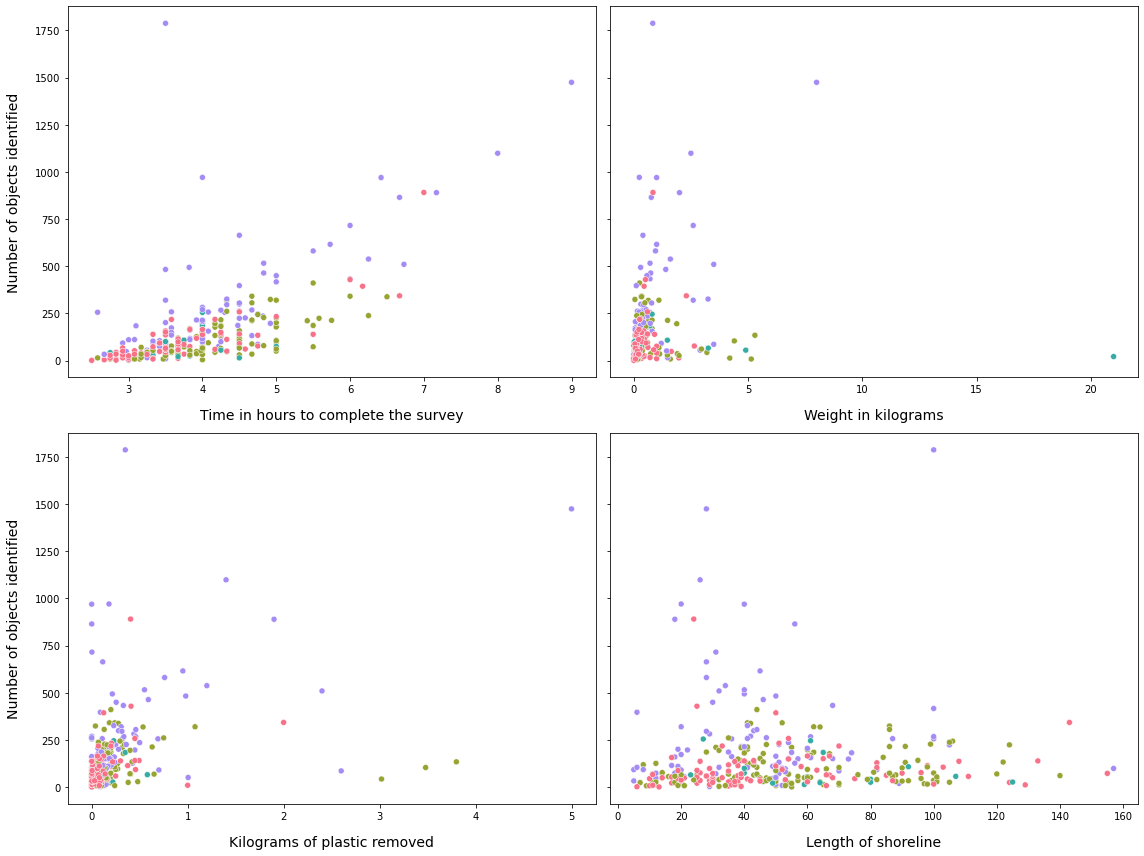

In [13]:
fig, axs = plt.subplots(2,2,figsize=(16,12), sharex=False, sharey=True)
sns.scatterplot(data=som_dims, x='time to survey', y='quantity', hue='river_bassin', palette='husl', ax=axs[0,0])
axs[0,0].get_legend().remove()
axs[0,0].set_xlabel("Time in hours to complete the survey", **xlab_k14 )
axs[0,0].set_ylabel("Number of objects identified", **xlab_k14)

sns.scatterplot(data=som_dims[som_dims['total weight'] < 50], x='total weight', y='quantity', hue='river_bassin', palette='husl', ax=axs[0,1])
axs[0,1].get_legend().remove()
axs[0,1].set_xlabel("Weight in kilograms", **xlab_k14 )
axs[0,1].set_ylabel("Number of objects identified", **xlab_k14)

sns.scatterplot(data=som_dims[som_dims['total weight'] < 50], x=som_dims[som_dims['total weight'] < 50]['plastic > 5mm weight']/1000, y='quantity', hue='river_bassin', palette='husl', ax=axs[1,0])
axs[1,0].get_legend().remove()
axs[1,0].set_xlabel("Kilograms of plastic removed", **xlab_k14 )
axs[1,0].set_ylabel("Number of objects identified", **xlab_k14)

sns.scatterplot(data=som_dims, x='meters surveyed', y='quantity', hue='river_bassin', palette='husl', ax=axs[1,1])
axs[1,1].get_legend().remove()
axs[1,1].set_xlabel("Length of shoreline", **xlab_k14 )
axs[1,1].set_ylabel("Number of objects identified", **xlab_k14)



plt.tight_layout()
plt.show()

#### Hopefully that just worked for you

if not contact analyst@hammerdirt.ch